In [19]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import numpy as np
from sklearn.manifold import TSNE
import torch
import glob
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from attrdict import AttrDict
import mmgclip
from sklearn.decomposition import PCA
from transformers import AutoTokenizer
from scipy.special import softmax

sns.set_theme(style="white", palette="coolwarm")

%matplotlib inline

Load the correct config (with the correct experiments path)

In [20]:
with initialize(config_path="../configs"):
    cfg = compose(config_name="train_binary_class_clf")

print(OmegaConf.to_yaml(cfg.base))

# convert the config dict to a class object
try:
    cfg['dataset']['config']['lists_dataset_path'] = "../data/02_data_lists/data/lists"
    cfg['dataset']['config']['annotated_dataset_path'] = "../data/02_data_T_regions"
    cfg['base']['features_export_dir'] = "../outputs/dataset"
    cfg['base']['export_dir'] = '../outputs/2024-05-06/16-58-29'
    cfg['base']['results_export_dir'] = '../outputs/2024-05-06/16-58-29/results'
    cfg['checkpoints']['checkpoints_export_dir'] = f'../outputs/2024-05-06/16-58-29/checkpoints'
    cfg['base']['tensorboard_export_dir'] = '../outputs/...'
    cfg['networks']['image_encoder']['convnext_tiny_clf_path'] = '../' + cfg['networks']['image_encoder']['convnext_tiny_clf_path']
    
    mmgconfig = AttrDict(cfg)
    print(mmgconfig)
except Exception as e:
    print("An error occurred:", e)

patience: 5
seed: 42
features_export_dir: outputs/dataset
export_dir: ${hydra:run.dir}
results_export_dir: ${hydra:run.dir}/results
tensorboard_export_dir: runs/${now:%Y-%m-%d}/${now:%H-%M-%S}

AttrDict({'checkpoints': {'checkpoints_export_dir': '../outputs/2024-05-06/16-58-29/checkpoints', 'checkpoints_file_name': 'model.pth'}, 'base': {'patience': 5, 'seed': 42, 'features_export_dir': '../outputs/dataset', 'export_dir': '../outputs/2024-05-06/16-58-29', 'results_export_dir': '../outputs/2024-05-06/16-58-29/results', 'tensorboard_export_dir': '../outputs/...'}, 'optimizer': {'name': 'adamw', 'config': {'learning_rate': 5e-05, 'weight_decay': 0.0001}}, 'scheduler': {'name': 'cosine', 'config': {'warmup_epochs': 0.1, 'epochs': 30}}, 'experiments': {'config': {'experiment_name': 'classification', 'metrics': ['${dataset.config.enums_class}']}}, 'dataset': {'name': 'ImageLabelDataset', 'config': {'enums_class': 'BenignMalignantDatasetLabels', 'search_col': 'image_label', 'generate_label_pr

In [21]:
mmgconfig['dataset']

{'name': 'ImageLabelDataset', 'config': {'enums_class': 'BenignMalignantDatasetLabels', 'search_col': 'image_label', 'generate_label_prompt_sentence': False, 'generate_label_prompt_report': False, 'base_dataset_path': '/storage/Features/features/png_archive/2D_100micron/0/', 'annotated_dataset_path': '../data/02_data_T_regions', 'lists_dataset_path': '../data/02_data_lists/data/lists'}, 'eval': {'enum_classes': ['BenignMalignantDatasetLabels'], 'method': ['ova', 'zeroshot_label_prompt'], 'dataset': {'name': 'ImageLabelDataset'}}, 'split': {'train_split_ratio': 0.7, 'test_split_ratio': 0.5}, 'template': {'prompt_template': '', 'label': [], 'template_keys': []}}

Load the model (image-label)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the pre-trained mmg-config model based on the experiment
ckp_path = os.path.join(mmgconfig.checkpoints.checkpoints_export_dir, mmgconfig.checkpoints.checkpoints_file_name)
print(f"ckp_path: {ckp_path}")
assert os.path.isfile(ckp_path), f'Checkpoint file path "{ckp_path}" does not exist.'
ckp_file = torch.load(ckp_path)

model = mmgclip.model(config=mmgconfig).to(device)
model.load_state_dict(ckp_file['model_state_dict'])
model.eval()

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model.config.tokenizer.config.tokenizer_name)

# load the encoder model
cnn_encoder = torch.jit.load(mmgconfig.networks.image_encoder.convnext_tiny_clf_path)
cnn_encoder.eval()

ckp_path: ../outputs/2024-05-06/16-58-29/checkpoints/model.pth


RecursiveScriptModule(
  original_name=ConvNeXt_spm
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=LayerNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=CNBlock
        (block): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=Permute)
          (2): RecursiveScriptModule(original_name=LayerNorm)
          (3): RecursiveScriptModule(original_name=Linear)
          (4): RecursiveScriptModule(original_name=GELU)
          (5): RecursiveScriptModule(original_name=Linear)
          (6): RecursiveScriptModule(original_name=Permute)
        )
        (stochastic_depth): RecursiveScriptModule(original_n

Preprocess the image-label dataset as in the dataset.py file.

In [23]:
def encode_image(model, batch: dict):
    with torch.no_grad():
        image_embeddings = model.encode_images(batch)
        image_embeddings = model.image_projection_layer(image_embeddings)
        image_embeddings = image_embeddings / torch.norm(image_embeddings, dim=1, keepdim=True)
    return image_embeddings.detach().cpu().numpy()

def encode_text(model, text_tokens):
    if isinstance(text_tokens, str) or isinstance(text_tokens, list):
        tokens = tokenizer(
            text_tokens, padding="longest", truncation=True, return_tensors="pt", max_length=mmgconfig.tokenizer.config.sequence_length
        )
        text_tokens = dict()

        text_tokens['text_tokens'] = tokens

    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens, text_pooling = 'eos')
        text_embeddings = model.text_projection_layer(text_embeddings)
        text_embeddings = text_embeddings / torch.norm(text_embeddings, dim=1, keepdim=True)
    return text_embeddings.detach().cpu().numpy()

In [24]:
# embeddings and labels for each sample placeholders
cnn_img_embeddings_X = []
cnn_labels_Y = []
cnn_probabilities = []

model_img_embeddings_X = []
model_txt_embeddings_X = []
model_labels_Y = cnn_labels_Y
model_probabilities = []

In [25]:
## An alternative to the above to run on all of the dataset
## -----------------------------------------------------------------------------------------

dataset_df = mmgclip.create_dataset_df(config=mmgconfig).sort_values('image_id').reset_index(drop=True)
print(dataset_df.shape)

data_path = os.path.join(mmgconfig.base.features_export_dir, '0/02')
dataset_pth = mmgclip.create_dataset_path(path=data_path).sort_values('image_id').reset_index(drop=True)
print(dataset_pth.shape)

dataset_pth = pd.merge(dataset_pth, dataset_df[['image_id', 'image_label', 'mass_shape', 'mass_margin', 'has_mass', 'has_architectural_distortion', 'has_calc']], on='image_id', how='inner')
print(dataset_pth.shape)

dataset_pth = dataset_pth[dataset_pth['image_label'] != 2].reset_index(drop=True)
print(dataset_pth.shape)

labels = np.unique(['malignant' if image_label == 1 else 'benign' for image_label in dataset_pth['image_label'].tolist()]).tolist()

## When using all of the dataset as commented in the cells above, uncomment the next section
## -----------------------------------------------------------------------------------------
for idx, row in dataset_pth[['image_label', 'image_path']].iterrows():
    image_label = 'malignant' if row['image_label'] == 1 else 'benign'
    image_path = row['image_path']

    image_features = torch.load(image_path)

    # append the cnn embeddings
    cnn_img_embeddings_X.append(image_features.flatten())
    cnn_labels_Y.append(image_label)

    # to allow 3D representation of the t-SNE plot, where the 3rd axis is the probability of belonging to a class
    logits = cnn_encoder.classifier(image_features).detach().cpu().numpy()
    similarities = softmax(logits / 2)
    cnn_probabilities.append(similarities)

    # append the model embeddings
    batch = {}
    batch['image_features'] = image_features
    
    image_embeddings = encode_image(model, batch)
    model_img_embeddings_X.append(image_embeddings)

    # to allow 3D representation of the t-SNE plot, where the 3rd axis is the probability of belonging to a class
    logit_scale = model.logit_scale.exp()
    logit_scale = logit_scale.detach().cpu().numpy()

    prompts = [f"Finding suggesting {label}." for label in labels]

    # pass to the tokenizer and encoder
    text_embeddings = encode_text(model, prompts)

    similarities = logit_scale * image_embeddings @ np.transpose(text_embeddings)
    similarities = softmax(similarities, axis=1)
    model_probabilities.append(similarities)


(6442, 8)
(6442, 2)
(6442, 8)
(4964, 8)


Store all the embeddings in a list, with their labels; then plot the t-SNE

In [26]:
# # If using only the test split, use the section below
# # -----------------------------------------------------------------------------------------

# clf_dataset = mmgclip.get_dataset(dataset_name=mmgconfig.dataset.name)(config=mmgconfig)
# mmgclip.logger.info(f"Description Example: {clf_dataset[0]['image_description']}")
# mmgclip.logger.info(f"Features Shape: {clf_dataset[0]['image_features'].shape}")

# # split the dataset for train, val, and test
# train_clf_split, val_clf_split = clf_dataset.random_split(dataset=clf_dataset, split='train')
# print(f"Train split len: ({len(train_clf_split)}), Valid split len ({len(val_clf_split)}).")

# if mmgconfig.dataset.name == mmgconfig.dataset.eval.dataset.name:
#     # if we train and evaluate using the same type of dataset, then split the valid with the test
#     val_clf_split, test_clf_split = clf_dataset.random_split(dataset=val_clf_split, split='test')
#     print(f"Test split len ({len(test_clf_split)}).")

# else:
#     print("Using different dataset for testing, thus not splitting validation dataset.")

# # obtaining the unique labels
# labels = np.unique([sample['image_description'] for sample in test_clf_split]).tolist()

# # If using only the test split, use the section below
# # -----------------------------------------------------------------------------------------

# for sample in test_clf_split:
#     image_features = sample['image_features']
#     image_label = sample['image_description']

#     # append the cnn embeddings
#     cnn_img_embeddings_X.append(image_features.flatten())
#     cnn_labels_Y.append(image_label)

#     # to allow 3D representation of the t-SNE plot, where the 3rd axis is the probability of belonging to a class
#     logits = cnn_encoder.classifier(image_features).detach().cpu().numpy()
#     similarities = softmax(logits / 2)
#     cnn_probabilities.append(similarities)

#     # append the model embeddings
#     batch = {}
#     batch['image_features'] = image_features
    
#     image_embeddings = encode_image(model, batch)
#     model_img_embeddings_X.append(image_embeddings)

#     # to allow 3D representation of the t-SNE plot, where the 3rd axis is the probability of belonging to a class
#     logit_scale = model.logit_scale.exp()
#     logit_scale = logit_scale.detach().cpu().numpy()

#     prompts = [f"Finding suggesting {label}." for label in labels]

#     # pass to the tokenizer and encoder
#     text_embeddings = encode_text(model, prompts)

#     similarities = logit_scale * image_embeddings @ np.transpose(text_embeddings)
#     similarities = softmax(similarities, axis=1)
#     model_probabilities.append(similarities)
# # -----------------------------------------------------------------------------------------


In [27]:
cnn_img_embeddings_X = np.vstack(cnn_img_embeddings_X)
cnn_labels_Y = np.vstack(cnn_labels_Y)
cnn_probabilities = np.vstack(cnn_probabilities)

model_img_embeddings_X = np.vstack(model_img_embeddings_X)
model_labels_Y = np.vstack(model_labels_Y)
model_probabilities = np.vstack(model_probabilities)

In [28]:
model_probabilities

array([[0.3167966 , 0.6832034 ],
       [0.38259912, 0.6174009 ],
       [0.5106932 , 0.48930675],
       ...,
       [0.6967811 , 0.30321893],
       [0.11609839, 0.8839016 ],
       [0.6530118 , 0.34698823]], dtype=float32)

In [29]:
pd.DataFrame(cnn_labels_Y).value_counts()

benign       3311
malignant    1653
Name: count, dtype: int64

In [30]:
cnn_img_embeddings_X.shape, cnn_labels_Y.shape, cnn_probabilities.shape

((4964, 768), (4964, 1), (4964, 2))

In [31]:
model_img_embeddings_X.shape, model_labels_Y.shape, model_probabilities.shape

((4964, 512), (4964, 1), (4964, 2))

In [32]:
cnn_labels_Y

array([['benign'],
       ['benign'],
       ['benign'],
       ...,
       ['malignant'],
       ['malignant'],
       ['malignant']], dtype='<U9')

In [33]:
def plot_tSNE(embeddings = None, labels = None, probabilities = None, plot_3d = False, remove_ax = False, n_components = 2, perplexity = 40, n_iter=300, title='', verbos= 0):
    if plot_3d == True:
        if probabilities is None: return ValueError("Probabilities are required when plot_3d is True.") 

    color_list = ["#192847", "#E12939", "#00FF1B", "#FF0000", "#FF9B00"]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d' if plot_3d else None) 

    def _reduce_dim_PCA(embeddings, n_components=50):
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(embeddings)
        return pca_result

    def _project_tSNE(embeddings):
        '''Returns the fitted t-SNE embeddings.'''
        # create a TSNE model
        tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=40, verbose=verbos)

        # return the fitted results
        return tsne.fit_transform(embeddings)

    projected_results = _project_tSNE(embeddings=embeddings) # _reduce_dim_PCA(embeddings)
    # projected_results = _project_tSNE(embeddings=_reduce_dim_PCA(embeddings))
    # projected_results = _reduce_dim_PCA(embeddings)

    for i, label in enumerate(np.unique(labels.flatten())):
        idx = np.where(labels == label)

        if plot_3d:
            ax.scatter(projected_results[idx, 0], projected_results[idx, 1], probabilities[idx, 1], s=6, alpha=0.6, color=color_list[i], label=label)
        else:
            plt.scatter(projected_results[idx, 0], projected_results[idx, 1], s=6, alpha=0.6, color=color_list[i], label=label)
            # plt.scatter(projected_results[idx, 0], probabilities[idx, 1], s=6, alpha=0.6, color=color_list[i], label=label)

    plt.title(title) if title != '' else None
    ax.set_xlabel('t-SNE Dimension 1') if plot_3d else plt.xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2') if plot_3d else plt.ylabel('t-SNE Dimension 2') # 't-SNE Dimension 2'
    ax.set_zlabel('Probabilities Dimension 3') if plot_3d else None
    ax.legend() if plot_3d else plt.legend()

    # Remove the plot borders by setting the spines' visibility to False
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide the x and y axis tick labels
    # ax.set_xticks([])
    # ax.set_yticks([])

    # Adjust layout to avoid cropping of axis labels
    plt.tight_layout()

    if remove_ax:
        # Remove grid lines
        ax.grid(False)

        # Remove axis lines
        ax.axis('off')

    plt.show()

    # return projected_results

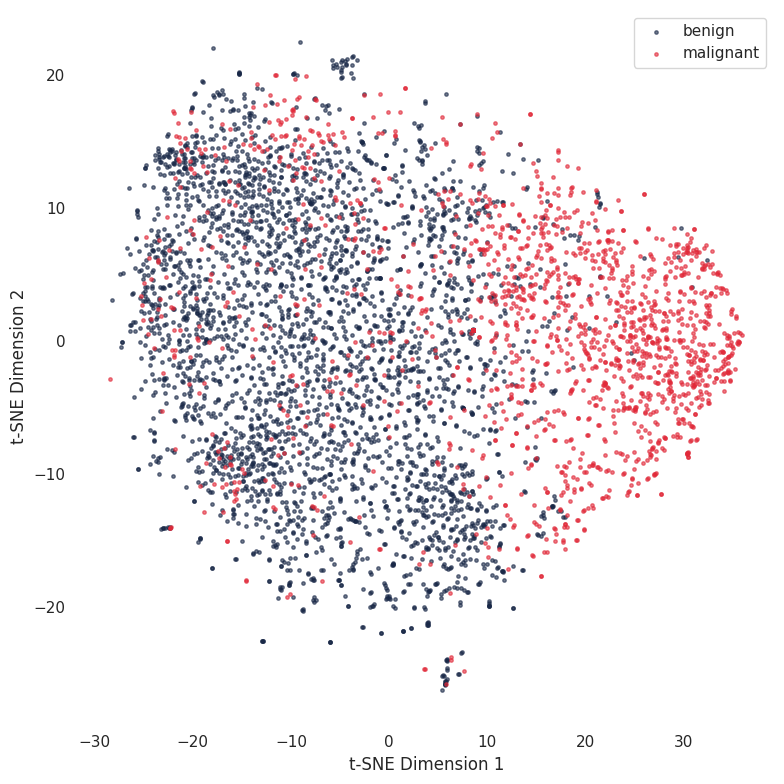

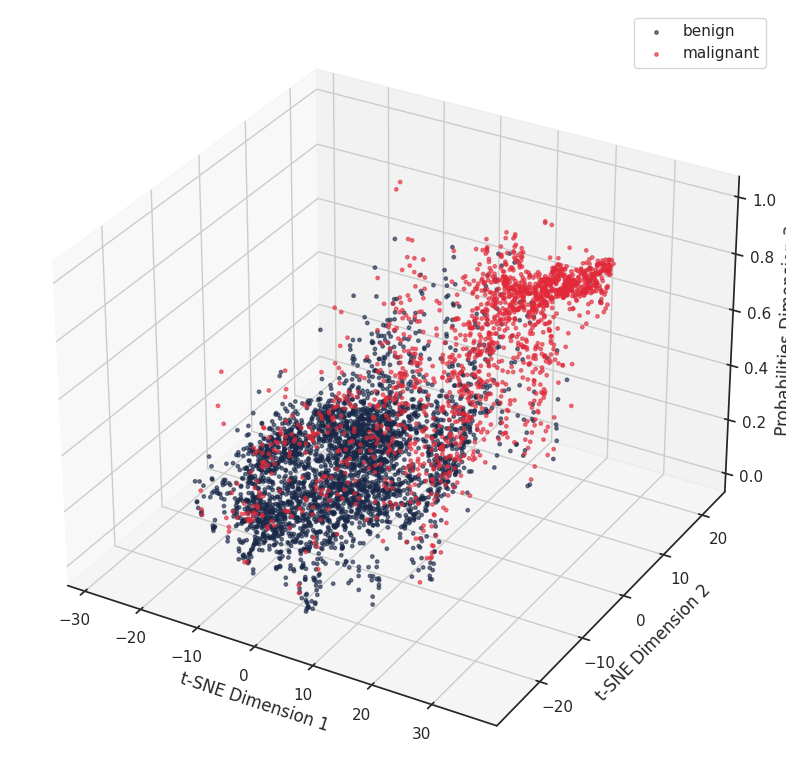

In [34]:
# 3d plot
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, probabilities=cnn_probabilities, plot_3d=True, perplexity=30, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')

# 2d plot
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=100, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')

plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, probabilities=cnn_probabilities, perplexity=50, n_iter=600) # title='t-SNE of CNN Encoder (Baseline) Embeddings'
plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, probabilities=cnn_probabilities, plot_3d = True, perplexity=50, n_iter=600) # title='t-SNE of CNN Encoder (Baseline) Embeddings'

# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=100, n_iter=600, title='t-SNE of CNN Encoder (Baseline) Embeddings')
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=100, n_iter=900, title='t-SNE of CNN Encoder (Baseline) Embeddings')

# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=50, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=40, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=30, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=20, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')
# plot_tSNE(embeddings = cnn_img_embeddings_X, labels = cnn_labels_Y, perplexity=10, n_iter=300, title='t-SNE of CNN Encoder (Baseline) Embeddings')

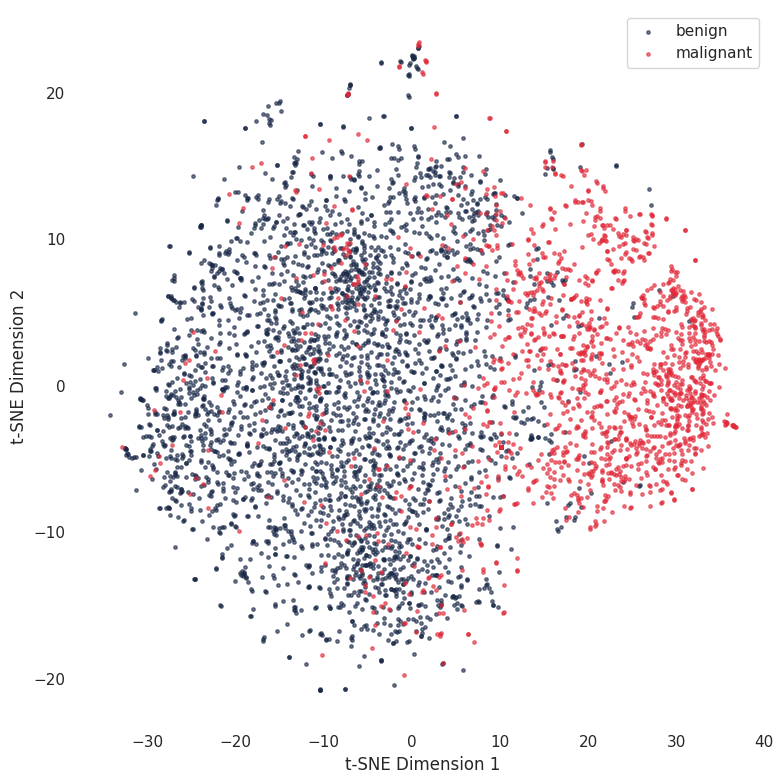

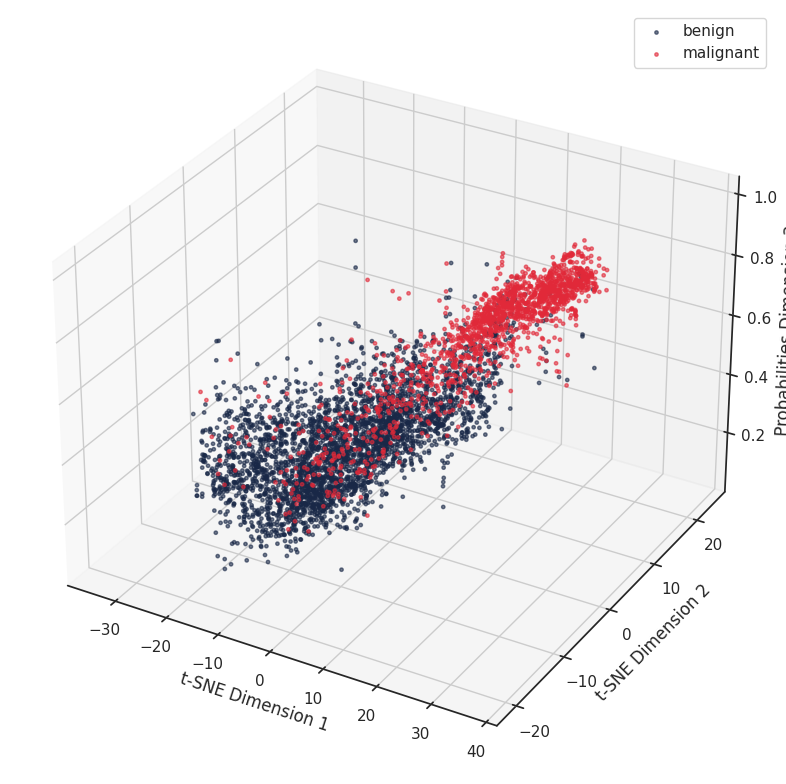

In [35]:
# 3d plot
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, probabilities=model_probabilities, plot_3d=True, perplexity=30, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")

# 2d plot
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=100, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=50, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")

plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, probabilities=model_probabilities, perplexity=50, n_iter=600) # title="t-SNE of CNN + Projection Layers Embeddings"
plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, probabilities=model_probabilities, plot_3d=True, perplexity=50, n_iter=600) # title="t-SNE of CNN + Projection Layers Embeddings"


# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=10, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=20, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=30, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=40, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
# plot_tSNE(embeddings=model_img_embeddings_X, labels=model_labels_Y, perplexity=50, n_iter=300, title="t-SNE of CNN + Projection Layers Embeddings")
